In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import numpy as np

2024-12-28 00:56:48.245959: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-28 00:56:48.254915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735347408.265178   14649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735347408.267924   14649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 00:56:48.278574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print(x_train.shape[0], 'train samples')
print('image shape', x_train[0].shape)

60000 train samples
image shape (28, 28)


In [3]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

input shape:  784


In [4]:
optim = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


I0000 00:00:1735347411.384970   14649 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8518 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [6]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [7]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

/home/user/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/user/.local/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [8]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

epoch:  0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


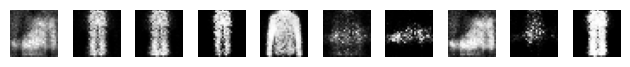

epoch:  1
epoch:  2
epoch:  3
epoch:  4
epoch:  5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


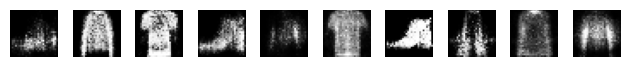

epoch:  6
epoch:  7
epoch:  8
epoch:  9
epoch:  10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


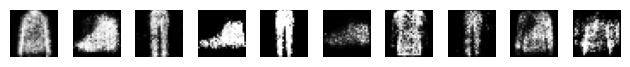

epoch:  11
epoch:  12
epoch:  13
epoch:  14
epoch:  15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


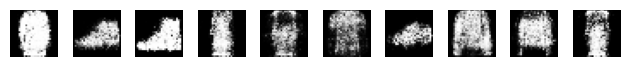

epoch:  16


In [ ]:
discrim_losses = []

def train_model(epochs, batch_size):
    # Перед началом обучения
    discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        print('epoch: ', ep)
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            generated_images = generator.predict(noise, verbose=0)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9 

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 5 == 0:
            plot_generated_images(ep, generator)

epochs = 20
batch_size = 128
train_model(epochs, batch_size)